In [9]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv("../data/processed_sales.csv", parse_dates=["date"])
df = df.sort_values(["model", "date"]).reset_index(drop=True)

# Preview
df.head()

,model,date,SEMAINE_NUM,sales,is_promo,product_age_weeks,product_age_years,PRIX_DE_DETAIL,NOMBRE_CLIENT_FIN_CONTRAT,CROIS_BYOD,week_of_year,month,year
0,IPHONE 12,2022-11-12 00:00:00+00:00,1,85,0,108,2,882.0,115.0,0.2,45,11,2022
1,IPHONE 12,2022-11-19 00:00:00+00:00,2,58,0,109,2,882.0,140.0,0.2,46,11,2022
2,IPHONE 12,2022-11-26 00:00:00+00:00,3,108,0,110,2,882.0,119.0,0.2,47,11,2022
3,IPHONE 12,2022-12-03 00:00:00+00:00,4,257,0,111,2,882.0,116.0,0.2,48,12,2022
4,IPHONE 12,2022-12-10 00:00:00+00:00,5,235,0,112,2,882.0,128.0,0.2,49,12,2022


In [10]:
def add_lag_features(df, lags, windows):
    df = df.copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby("model")["sales"].shift(lag)

    for window in windows:
        df[f"rolling_mean_{window}"] = df.groupby("model")["sales"].shift(1).rolling(window).mean()
        df[f"rolling_std_{window}"] = df.groupby("model")["sales"].shift(1).rolling(window).std()

    return df

# Define lags and rolling windows
lags = [1, 2, 3, 4, 5, 6, 7, 14]
windows = [3, 4, 8]

df = add_lag_features(df, lags, windows)

In [11]:
# Drop rows with missing lag features
df = df.dropna().reset_index(drop=True)

# Select one model for now (we'll generalize later)
model_name = "IPHONE 14"
df_model = df[df["model"] == model_name].copy()

# Find last 8-week window with significant volatility
threshold_ratio = 0.9  # std must be > 10% of mean

for i in range(len(df_model) - 8, 0, -1):
    window = df_model.iloc[i:i+8]
    mean_sales = window["sales"].mean()
    std_sales = window["sales"].std()

    if std_sales > threshold_ratio * mean_sales:
        test_window = window.copy()
        test_dates = test_window["date"]
        break
else:
    raise ValueError("No volatile 8-week test window found.")

# Train = everything before test
train_window = df_model[df_model["date"] < test_dates.min()].copy()

# Tag sets
df_model["set"] = "unused"
df_model.loc[df_model["date"].isin(train_window["date"]), "set"] = "train"
df_model.loc[df_model["date"].isin(test_dates), "set"] = "test"

In [12]:
print("Original Dataset:")
print(f"Start: {df_model['date'].min().date()}")
print(f"End  : {df_model['date'].max().date()}")
print(f"Weeks: {df_model.shape[0]}")

print("\nTrain window:")
print(f"Start: {df_model[df_model.set=='train']['date'].min().date()}")
print(f"End  : {df_model[df_model.set=='train']['date'].max().date()}")
print(f"Weeks: {df_model[df_model.set=='train'].shape[0]}")

print("\nTest window (volatile 8-week span):")
print(f"Start: {df_model[df_model.set=='test']['date'].min().date()}")
print(f"End  : {df_model[df_model.set=='test']['date'].max().date()}")
print(f"Weeks: {df_model[df_model.set=='test'].shape[0]}")

Original Dataset:
Start: 2023-02-18
End  : 2025-02-08
Weeks: 104

Train window:
Start: 2023-02-18
End  : 2024-08-10
Weeks: 78

Test window (volatile 8-week span):
Start: 2024-08-17
End  : 2024-10-05
Weeks: 8


In [13]:
# Features to use
feature_cols = [
    "is_promo", "product_age_weeks", "PRIX_DE_DETAIL", 
    "NOMBRE_CLIENT_FIN_CONTRAT", "CROIS_BYOD", "week_of_year", "month", "year"
] + [f"lag_{l}" for l in lags] + [f"rolling_mean_{w}" for w in windows] + [f"rolling_std_{w}" for w in windows]

X_train = df_model[df_model["set"] == "train"][feature_cols]
y_train = df_model[df_model["set"] == "train"]["sales"]
X_test = df_model[df_model["set"] == "test"][feature_cols]
y_test = df_model[df_model["set"] == "test"]["sales"]

In [14]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 22
[LightGBM] [Info] Start training from score 1001.525641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [15]:
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)  # avoid negative predictions

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100 if not (y_test == 0).all() else np.nan
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100 if y_test.sum() > 0 else np.nan

print(f"LightGBM – {model_name}")
print(f"  MAE  = {mae:.2f}")
print(f"  RMSE = {rmse:.2f}")
print(f"  MAPE = {mape:.2f}%")
print(f"  WAPE = {wape:.2f}%")

LightGBM – IPHONE 14
  MAE  = 229.59
  RMSE = 291.62
  MAPE = 62.94%
  WAPE = 48.55%


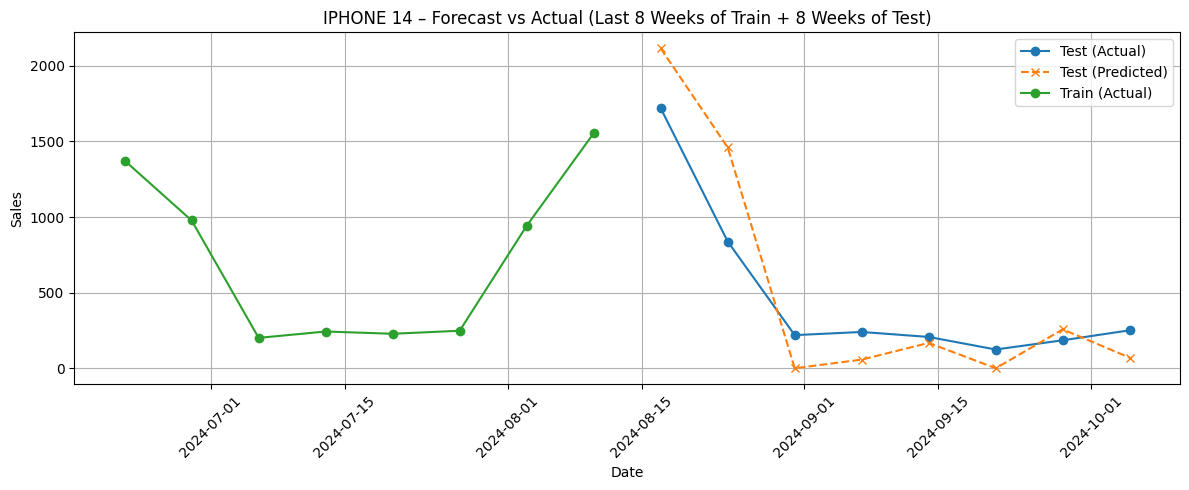

In [16]:
import matplotlib.pyplot as plt

# Extract last 8 weeks of train data
train_last_8 = df_model[(df_model["set"] == "train")].tail(8).copy()
train_last_8["y_type"] = "Train (Actual)"
test_actual = df_model[df_model["set"] == "test"].copy()
test_actual["y_type"] = "Test (Actual)"
test_pred = test_actual.copy()
test_pred["sales"] = y_pred
test_pred["y_type"] = "Test (Predicted)"

# Combine all
plot_df = pd.concat([train_last_8, test_actual, test_pred])
plot_df = plot_df.sort_values("date")

# Plot
plt.figure(figsize=(12, 5))
for label, df_grp in plot_df.groupby("y_type"):
    plt.plot(df_grp["date"], df_grp["sales"], label=label, marker="o" if "Actual" in label else "x",
             linestyle="--" if "Predicted" in label else "-")

plt.title(f"{model_name} – Forecast vs Actual (Last 8 Weeks of Train + 8 Weeks of Test)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this notebook, we trained a **LightGBM** model on supervised features derived from historical iPhone sales data and tested it on an 8-week **volatile segment** of the time series. This approach helps assess how the model performs in realistic high-variance conditions — such as during promotions, launches, or seasonal peaks.

**LightGBM Performance on IPHONE 14 (Volatile 8-week test):**

- **MAE**: 229.59  
- **RMSE**: 291.62  
- **MAPE**: 62.94%  
- **WAPE**: 48.55%

Compared to Prophet and Naive baselines in previous notebooks, **LightGBM** showed stronger predictive power, especially in handling fluctuations across time thanks to its engineered features (lags, rolling stats, calendar effects, etc.).
